(highres-downsample)=
# Einlesen und downsamplen zeitlich hochaufgelöster Daten

Dieses Notebook wird in [diesem Video](https://vimeo.com/649453887/783225f25e) verwendet.

In diesem Notebook wird gezeigt, wie man zeitlich hochaufgelöste Daten einlesen und downsamplen kann. Das wird relevant, je höher die zeiltiche Auflösung und je länger der dargestellte Zeitraum der Daten ist. Hat man z.B. eine Messung über ein Jahr mit einer zeitlichen Auflösung von $\frac{1}{30}$ Millisekunde, so sind das $9,4\cdot10^{11}$ Messwerte.

Wenn man diese Daten auf einmal alle einliest, kann es schon vorkommen, dass der Arbeitsspeicher mit einem Schlag randvoll ist. Das wiederum beeinträchtigt dann die Leistung des Rechners. Häufig sind so hohe zeitliche Auflösungen auch gar nicht nötig/sinnvoll.

Die Lösung für dieses Problem ist es, die Daten nur "häppchenweise" einzulesen und diese "Häppchen" dann schon direkt downzusamplen. Im Folgenden wird dies an einem Beispiel vorgeführt.

In [1]:
import os
import requests
import zipfile as zf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [2]:
sns.set(style = "darkgrid")
sns.set(rc = {"figure.figsize" : (16, 5)})

rcParams['font.size'] = 12

## Beispiel: hochaufgelöste Daten, kurzer Zeitraum

Die Daten zu diesem Beispiel finden sich auf [figshare](https://figshare.com/articles/dataset/PLAID_-_A_Voltage_and_Current_Measurement_Dataset_for_Plug_Load_Appliance_Identification_in_Households/10084619/2?file=18183113) und werden erklärt in {cite:p}`medico_voltage_2020`. In der unteren Code-Zelle wird geprüft, ob die Daten bereits vorhanden sind. Wenn nicht, folgt der Download.

Aus den [zugehörigen Metadaten](https://figshare.com/articles/dataset/PLAID_-_A_Voltage_and_Current_Measurement_Dataset_for_Plug_Load_Appliance_Identification_in_Households/10084619/2?file=19812578) wird ersichtlich, dass es sich hierbei um die Strom- und Spannungsmessdaten einer Kompaktleuchtstofflampe handelt. Die Daten sind mit einer Messfrequenz von $30kHz$ aufgenommen.

In [3]:
# sind die Daten bereits vorhanden? falls nein:
if not os.path.isfile('../data/submetered_new/2.csv'):
    print('Daten noch nicht vorhanden, starte Download...')
    url = 'https://ndownloader.figshare.com/files/18183113'
    filename = 'data.zip'
    # Download
    r = requests.get(url, allow_redirects=True)
    print('...fertig!')
    # Daten schreiben
    open(filename, 'wb').write(r.content)
    # Daten durchsuchen
    with zf.ZipFile(filename, 'r') as obj_zip:
        file_names = obj_zip.namelist()
        for name in file_names:
            if name == 'submetered_new/2.csv':
                # passende Daten extrahieren
                obj_zip.extract(name, path="../data")
    # den Rest löschen
    os.remove(filename)
    lampen_daten = pd.read_csv('../data/submetered_new/2.csv', names=['Strom [A]', 'Spannung [V]'])
            
# falls doch: 
else:
    print('Daten bereits vorhanden!')
    lampen_daten = pd.read_csv('../data/submetered_new/2.csv', names=['Strom [A]', 'Spannung [V]'])
    

Daten bereits vorhanden!


In [4]:
lampen_daten.shape

(60000, 2)

Aha, das sind also 60.000 Messzeitpunkte; bei einer Messfrequenz von 30 kHz sind das gerade mal 2 Sekunden.

Mal die Leistung anschauen:

In [5]:
lampen_daten['Leistung [W]'] = lampen_daten['Strom [A]'] * lampen_daten['Spannung [V]']

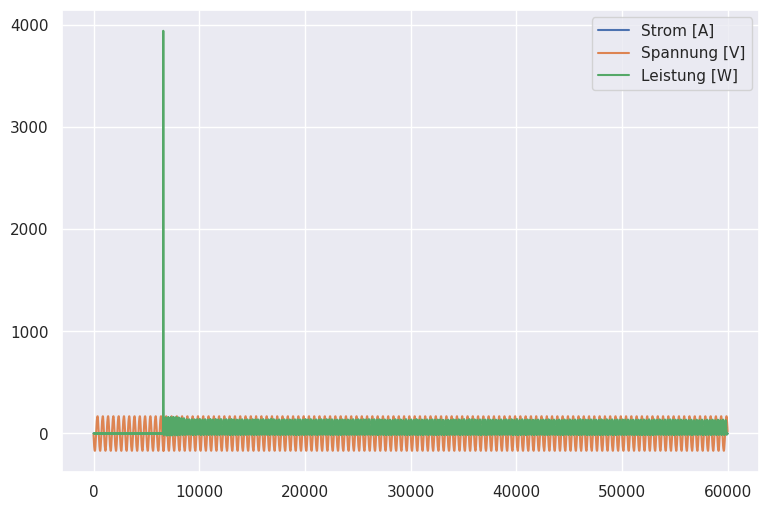

In [6]:
lampen_daten.plot(figsize=(9,6))
plt.show()

Mal einen ordentlichen Index machen:

In [7]:
lampen_daten.index = pd.date_range(start='2020', periods=len(lampen_daten), freq='33us')

In [8]:
lampen_daten.plot(figsize=(9,6))
plt.show()

KeyboardInterrupt: 

Die mittlere Leistung berechnen:

In [ ]:
P_mittel = lampen_daten['Leistung [W]'].mean()
print('Die mittlere Leistung beträgt {} W'.format(np.round(P_mittel, 1)))

Aber ist für diese Erkenntnis wirklich die hohe zeitliche Auflösung nötig? Dafür wird im Folgenden die Messfrequenz _downgesampled_ mithilfe des Befehls ``.resample()``. Anschließend werden in den neuen, größeren Messintervallen alle Messwerte aggregiert und deren Mittelwert berechnet mithilfe von ``.mean()``.

In [ ]:
lampen_daten_kompakt = lampen_daten.resample('10ms').mean()

In [ ]:
lampen_daten_kompakt.plot(figsize=(14,7))
plt.show()

In [ ]:
P_mittel_kompakt = lampen_daten_kompakt['Leistung [W]'].mean()
print('Die mittlere Leistung beträgt {}W.'.format(np.round(P_mittel_kompakt, 1)))

Das passt immer noch, trotz geringerer zeitlicher Auflösung. Zwar ist in dieser Darstellung nicht mehr der Netzsinus zu erkennen (da die neue Frequenz (50 ms entsprechen 20 Hz) geringer als die Netzfrequenz ist). Zur Berechnung der Leistung oder der bezogenen Energie genügt es aber trotzdem.

## Beispiel: hoch aufgelöste Daten, langer Zeitraum

Als Beispiel dienen die Daten vom vorherigen Beispiel. Hätte man dieselbe Messung, bloß über ein Jahr, dann ergäben sich $9,46\cdot10^{11}$ Messwerte. Bei float-Zahlen zu jeweils 8 byte wären das $7,57\cdot10^{12}$ byte oder 7,57 Terabyte. Viel zu viel für den Arbeitsspeicher (und vermutlich auch für die ganze Festplatte). Der Versuch, diese Daten auf einmal einzulesen, würde nur zu einer Fehlermeldung führen. Hier bietet es sich an, die Daten in kleineren "Häppchen" einzulesen und diese "Häppchen" dann direkt downzusamplen, bevor alles appendiert wird (für das Vorgehen siehe z.B. [hier](https://www.youtube.com/watch?v=97t9zmXeyD0&t=3s) oder [hier](https://stackoverflow.com/questions/25962114/how-do-i-read-a-large-csv-file-with-pandas)).

Für das stückchenweise Einlesen der Daten kann der Parameter ``chunksize`` genutzt werden. Näheres hierzu gibt es z.B. auch in der [pandas-Doku](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-chunking)

In [ ]:
chunks = pd.read_csv('../data/submetered_new/2.csv', names=['Strom [A]', 'Spannung [V]'], chunksize=5e3)
chunk_list = []
for chunk in chunks:
    chunk['Leistung [W]'] = chunk['Strom [A]'] * chunk['Spannung [V]']
    chunk.index = pd.date_range(start='2020', periods=len(chunk), freq='33us')
    chunk_kompakt = chunk.resample('10ms').mean()
    chunk_list.append(chunk_kompakt)
    
result = pd.concat(chunk_list, ignore_index=True)

In [ ]:
result.plot(figsize=(14,7))
plt.show()

In [ ]:
result['Leistung [W]'].mean()

```{bibliography}
:filter: docname in docnames
```